<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/Chapter8FocalImaging/1DCoherenceTransferFunction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The 1D coherence transfer function
## David Brady
## University of Arizona
## January 2025

This notebook plots some simple figures to illuminate the discussion in section 8.5 of **Computational Optical Imaging**

Most of the code in this notebook was created with the help of ChatGPT 01

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'font.size': 28})

In [ ]:


def rect_ambiguity(tau, nu, T):
    """
    Compute the ambiguity function A_f(tau, nu) for a rectangular pulse of duration T.

    A_f(tau, nu) = (T - |tau|) * exp(-i * 2*pi*nu*(tau/2)) * sinc[ nu*(T - |tau|) ], if |tau| < T
                 = 0, otherwise

    Returns a complex array corresponding to the values of A_f at each (tau, nu).

    Code generated by ChatGPT-01 Pro
    """
    # Initialize an array of complex zeros.
    A = np.zeros_like(tau, dtype=complex)

    # Create a mask for the region where |tau| < T
    mask = np.abs(tau) < T

    # Handle that region
    # (T - |tau|)
    T_minus_abs_tau = T - np.abs(tau[mask])

    # The argument for the sinc
    x = nu[mask] * T_minus_abs_tau

    # Compute sinc(x) = sin(pi*x)/(pi*x)
    # Use np.where to handle the x=0 case properly if desired, but numpy handles
    # sin(0)/0 in a stable manner if we manage floating errors carefully.
    with np.errstate(divide='ignore', invalid='ignore'):
        sinc_x = np.sin(np.pi * x) / (np.pi * x)
        # Replace any NaNs (from 0/0) with 1, which is the limiting value of sinc at x=0
        sinc_x = np.where(np.isnan(sinc_x), 1.0, sinc_x)

    # Phase factor e^{-i 2 pi nu (tau/2)}
    phase_factor = np.exp(-1j * 2.0 * np.pi * nu[mask] * (tau[mask] / 2.0))

    # Combine amplitude and phase
    A[mask] = T_minus_abs_tau * phase_factor * sinc_x

    return A



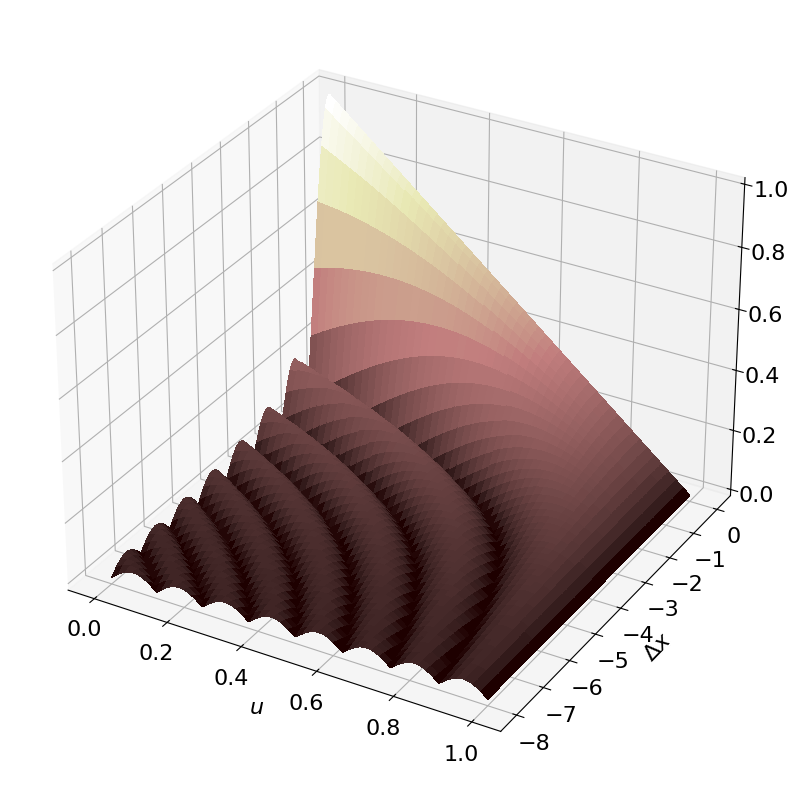

In [ ]:
# ------------------
# MAIN SCRIPT BEGINS
# ------------------

# Parameters
T = 1.0           # Duration of the rectangular pulse
tau_min, tau_max = -0*T, 1*T
nu_min,  nu_max  = -8,    0

# Grid resolution
N_tau = 500
N_nu  = 500

# Create equally spaced values of tau and nu
tau_vals = np.linspace(tau_min, tau_max, N_tau)
nu_vals  = np.linspace(nu_min,  nu_max,  N_nu)

# Create a meshgrid of tau and nu
TAU, NU = np.meshgrid(tau_vals, nu_vals)

# Compute the ambiguity function on the grid
A_vals = rect_ambiguity(TAU, NU, T)

# We will visualize the magnitude of A_f(tau, nu)
A_mag = np.abs(A_vals)

# Create a 3D surface plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# plot_surface expects X, Y, and Z as 2D arrays
surf = ax.plot_surface(TAU, NU, A_mag, cmap='pink', linewidth=0, antialiased=False)
ax.set_xlabel(r'$u$')
ax.set_ylabel(r'$\Delta x$')
#ax.set_zlabel(r'$|H(u, \Delta x)|$')

# Add a color bar
#fig.colorbar(surf, shrink=0.5, aspect=10)
plt.savefig('rect_ambiguity.png')



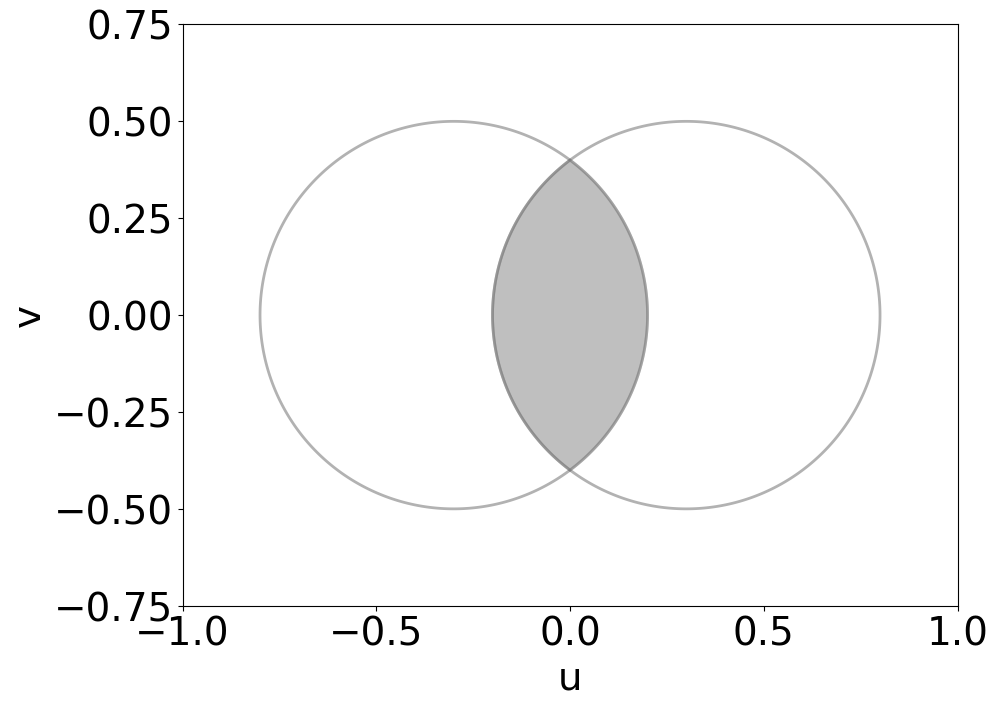

In [4]:

import matplotlib.patches as patches
from shapely.geometry import Point
from shapely.ops import unary_union
# written by chatgpt-01 pro

def shapely_polygon_to_mpl_patches(geom, **kwargs):
    """
    Convert a Shapely Polygon or MultiPolygon into one or more Matplotlib Patch objects.

    :param geom: A Shapely Polygon or MultiPolygon
    :param kwargs: Keyword arguments for matplotlib.patches.Polygon (e.g. facecolor, edgecolor)
    :return: A list of Matplotlib Polygon patches
    """
    patches_list = []

    # If it's a single Polygon
    if geom.geom_type == 'Polygon':
        exterior_coords = geom.exterior.coords[:]
        poly_patch = patches.Polygon(exterior_coords, closed=True, **kwargs)
        patches_list.append(poly_patch)

        # If the polygon has holes (interior rings), you can optionally plot them
        for interior in geom.interiors:
            interior_coords = interior.coords[:]
            hole_patch = patches.Polygon(interior_coords, closed=True, **kwargs)
            # You might choose a different color or alpha for holes
            patches_list.append(hole_patch)

    # If it's a MultiPolygon, recurse for each polygon
    elif geom.geom_type == 'MultiPolygon':
        for poly in geom.geoms:
            patches_list.extend(shapely_polygon_to_mpl_patches(poly, **kwargs))

    return patches_list

# --------------------------
# MAIN SCRIPT
# --------------------------
# Circle parameters
r = 0.5
center1 = Point(-0.3, 0)
center2 = Point(0.3, 0)

# Create Shapely circles (disks) of radius r
circle1 = center1.buffer(r, resolution=200)
circle2 = center2.buffer(r, resolution=200)

# Intersection (overlap)
overlap = circle1.intersection(circle2)

# Create a figure
fig, ax = plt.subplots(figsize=(10,10))

# Convert circle1 to patches
for patch in shapely_polygon_to_mpl_patches(circle1, facecolor='white', alpha=0.3, edgecolor='black', linewidth=2):
    ax.add_patch(patch)

# Convert circle2 to patches
for patch in shapely_polygon_to_mpl_patches(circle2, facecolor='white', alpha=0.3, edgecolor='black', linewidth=2):
    ax.add_patch(patch)

# Convert overlap region to patches (if not empty)
if not overlap.is_empty:
    for patch in shapely_polygon_to_mpl_patches(overlap, facecolor='gray', alpha=0.5, edgecolor='gray', linewidth=2):
        ax.add_patch(patch)

# Set plot limits so we can see the circles clearly
margin = 1
ax.set_xlim(-margin, margin)
ax.set_ylim(-.75, .75)
ax.set_aspect('equal', 'box')
ax.set_xlabel('u')
ax.set_ylabel('v')
plt.savefig('circle_intersection.png')
plt.show()
